https://www.kaggle.com/code/greatcodes/pytorch-cnn-resnet18-cifar10/notebook

https://pytorch-tutorial.readthedocs.io/en/latest/tutorial/chapter03_intermediate/3_2_2_cnn_resnet_cifar10/

In [29]:
!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [30]:
# Importing Libraries
import os
import numpy as np
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

import matplotlib.pyplot as plt
%matplotlib inline

device = "cuda" if torch.cuda.is_available else "cpu"
print(device)

cuda


In [31]:
from torchvision import transforms
import numpy as np
import torch

# Returns a list of transformations when called

class GetTransforms():
    '''Returns a list of transformations when type as requested amongst train/test
       Transforms('train') = list of transforms to apply on training data
       Transforms('test') = list of transforms to apply on testing data'''

    def __init__(self):
        pass

    def trainparams(self):
        train_transformations = [ #resises the image so it can be perfect for our model.
            transforms.RandomHorizontalFlip(), # FLips the image w.r.t horizontal axis
            transforms.RandomRotation((-7,7)),     #Rotates the image to a specified angel
            transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Performs actions like zooms, change shear angles.
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Set the color params
            transforms.ToTensor(), # comvert the image to tensor so that it can work with torch
            transforms.Normalize((0.491, 0.482, 0.446), (0.247, 0.243, 0.261)) #Normalize all the images
            ]

        return train_transformations

    def testparams(self):
        test_transforms = [
            transforms.ToTensor(),
            transforms.Normalize((0.491, 0.482, 0.446), (0.247, 0.243, 0.261))
        ]
        return test_transforms

In [32]:
from torchvision import datasets
from torchvision import transforms


transformations = GetTransforms()
train_transforms = transforms.Compose(transformations.trainparams())
test_transforms = transforms.Compose(transformations.testparams())


class GetCIFAR10_TrainData():
    def __init__(self, dir_name:str):
        self.dirname = dir_name

    def download_train_data(self):
        return datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)

    def download_test_data(self):
        return datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)


In [33]:
data = GetCIFAR10_TrainData(os.chdir(".."))
trainset = data.download_train_data()
testset = data.download_test_data()
trainloader = torch.utils.data.DataLoader(trainset, batch_size=512,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=512,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


# The Model - RESNET18


In [34]:
# 3x3 convolution
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

In [35]:
# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.dropout1 = nn.Dropout(0.1)
        
        self.relu = nn.ReLU(inplace=True)
        
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.dropout2 = nn.Dropout(0.1)
        
        self.downsample = downsample

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        # out = self.dropout1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        # out = self.dropout2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        
        return out

# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        
        self.in_channels = 64
        
        self.conv = conv3x3(in_channels=3, out_channels=64)
        self.bn = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self.make_layer(block=block, out_channels=64, blocks=layers[0], stride=1)
        self.layer2 = self.make_layer(block=block, out_channels=128, blocks=layers[1], stride=2)
        self.layer3 = self.make_layer(block=block, out_channels=256, blocks=layers[2], stride=2)
        self.layer4 = self.make_layer(block=block, out_channels=512, blocks=layers[3], stride=2)

        self.avg_pool = nn.AvgPool2d(4)
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return F.log_softmax(out, dim=-1)

def ResNet18():
    return ResNet(ResidualBlock, [2, 2, 2, 2])

In [36]:
# Importing Model and printing Summary
model = ResNet18().to(device)
summary(model, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,864
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
              ReLU-9           [-1, 64, 32, 32]               0
    ResidualBlock-10           [-1, 64, 32, 32]               0
           Conv2d-11           [-1, 64, 32, 32]          36,864
      BatchNorm2d-12           [-1, 64, 32, 32]             128
             ReLU-13           [-1, 64, 32, 32]               0
           Conv2d-14           [-1, 64,

In [37]:
from tqdm import tqdm
from torch import nn
import torch.nn
from torch.functional import F
import os


def model_training(model, device, train_dataloader, optimizer, train_acc, train_losses):
            
    model.train()
    pbar = tqdm(train_dataloader)
    correct = 0
    processed = 0
    running_loss = 0.0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        y_pred = model(data)
        loss = F.nll_loss(y_pred, target)
        

        train_losses.append(loss.item())
        loss.backward()
        optimizer.step()

        pred = y_pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        # print statistics
        running_loss += loss.item()
        pbar.set_description(desc=f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)

In [38]:
import torch
import os
from torch.functional import F

cwd = os.getcwd()

def model_testing(model, device, test_dataloader, test_acc, test_losses, misclassified = []):
    
    model.eval()
    test_loss = 0
    correct = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    # label = 0
    classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    
    with torch.no_grad():

        for index, (data, target) in enumerate(test_dataloader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            
            for d,i,j in zip(data, pred, target):
                if i != j:
                    misclassified.append([d.cpu(),i[0].cpu(),j.cpu()])

            test_loss += F.nll_loss(output, target, reduction='sum').item()
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_dataloader.dataset)
    test_losses.append(test_loss)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_dataloader.dataset),
        100. * correct / len(test_dataloader.dataset)))
    
    test_acc.append(100. * correct / len(test_dataloader.dataset))
    return misclassified

In [39]:
# Training the model

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.05, patience=2, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=True)
# scheduler = StepLR(optimizer, step_size=15, gamma=0.1)

train_acc = []
train_losses = []
test_acc = []
test_losses = []

EPOCHS = 40

for i in range(EPOCHS):
    print(f'EPOCHS : {i}')
    model_training(model, device, trainloader, optimizer, train_acc, train_losses)
    scheduler.step(train_losses[-1])
    misclassified = model_testing(model, device, testloader, test_acc, test_losses)

EPOCHS : 0


Loss=1.2641723155975342 Batch_id=97 Accuracy=40.69: 100%|██████████| 98/98 [00:53<00:00,  1.84it/s]



Test set: Average loss: 1.2665, Accuracy: 5317/10000 (53.17%)

EPOCHS : 1


Loss=1.1053279638290405 Batch_id=97 Accuracy=59.11: 100%|██████████| 98/98 [00:50<00:00,  1.95it/s]



Test set: Average loss: 1.1265, Accuracy: 6192/10000 (61.92%)

EPOCHS : 2


Loss=0.8039460778236389 Batch_id=97 Accuracy=67.94: 100%|██████████| 98/98 [00:50<00:00,  1.92it/s]



Test set: Average loss: 0.8644, Accuracy: 6954/10000 (69.54%)

EPOCHS : 3


Loss=0.8006675243377686 Batch_id=97 Accuracy=72.80: 100%|██████████| 98/98 [00:51<00:00,  1.90it/s]



Test set: Average loss: 0.7900, Accuracy: 7269/10000 (72.69%)

EPOCHS : 4


Loss=0.6267491579055786 Batch_id=97 Accuracy=76.26: 100%|██████████| 98/98 [00:52<00:00,  1.88it/s]



Test set: Average loss: 0.7477, Accuracy: 7440/10000 (74.40%)

EPOCHS : 5


Loss=0.5839677453041077 Batch_id=97 Accuracy=78.34: 100%|██████████| 98/98 [00:52<00:00,  1.87it/s]



Test set: Average loss: 0.6753, Accuracy: 7756/10000 (77.56%)

EPOCHS : 6


Loss=0.6324280500411987 Batch_id=97 Accuracy=80.59: 100%|██████████| 98/98 [00:52<00:00,  1.86it/s]



Test set: Average loss: 0.6605, Accuracy: 7804/10000 (78.04%)

EPOCHS : 7


Loss=0.5852837562561035 Batch_id=97 Accuracy=82.47: 100%|██████████| 98/98 [00:52<00:00,  1.86it/s]



Test set: Average loss: 0.5529, Accuracy: 8129/10000 (81.29%)

EPOCHS : 8


Loss=0.4556937515735626 Batch_id=97 Accuracy=83.64: 100%|██████████| 98/98 [00:52<00:00,  1.87it/s]



Test set: Average loss: 0.5137, Accuracy: 8271/10000 (82.71%)

EPOCHS : 9


Loss=0.4591841995716095 Batch_id=97 Accuracy=84.67: 100%|██████████| 98/98 [00:52<00:00,  1.86it/s]



Test set: Average loss: 0.5208, Accuracy: 8293/10000 (82.93%)

EPOCHS : 10


Loss=0.42775440216064453 Batch_id=97 Accuracy=86.06: 100%|██████████| 98/98 [00:52<00:00,  1.87it/s]



Test set: Average loss: 0.6059, Accuracy: 8113/10000 (81.13%)

EPOCHS : 11


Loss=0.35262560844421387 Batch_id=97 Accuracy=86.63: 100%|██████████| 98/98 [00:52<00:00,  1.87it/s]



Test set: Average loss: 0.4757, Accuracy: 8383/10000 (83.83%)

EPOCHS : 12


Loss=0.41278985142707825 Batch_id=97 Accuracy=87.49: 100%|██████████| 98/98 [00:52<00:00,  1.87it/s]



Test set: Average loss: 0.4803, Accuracy: 8462/10000 (84.62%)

EPOCHS : 13


Loss=0.2669268250465393 Batch_id=97 Accuracy=88.31: 100%|██████████| 98/98 [00:52<00:00,  1.87it/s]



Test set: Average loss: 0.4509, Accuracy: 8527/10000 (85.27%)

EPOCHS : 14


Loss=0.2888171672821045 Batch_id=97 Accuracy=88.91: 100%|██████████| 98/98 [00:52<00:00,  1.86it/s]



Test set: Average loss: 0.5179, Accuracy: 8310/10000 (83.10%)

EPOCHS : 15


Loss=0.2882102429866791 Batch_id=97 Accuracy=89.58: 100%|██████████| 98/98 [00:52<00:00,  1.86it/s]



Test set: Average loss: 0.4586, Accuracy: 8519/10000 (85.19%)

EPOCHS : 16


Loss=0.25772625207901 Batch_id=97 Accuracy=89.95: 100%|██████████| 98/98 [00:52<00:00,  1.87it/s]



Test set: Average loss: 0.5030, Accuracy: 8416/10000 (84.16%)

EPOCHS : 17


Loss=0.3257617652416229 Batch_id=97 Accuracy=90.66: 100%|██████████| 98/98 [00:53<00:00,  1.85it/s]



Test set: Average loss: 0.4391, Accuracy: 8585/10000 (85.85%)

EPOCHS : 18


Loss=0.2969689667224884 Batch_id=97 Accuracy=91.23: 100%|██████████| 98/98 [00:52<00:00,  1.87it/s]



Test set: Average loss: 0.4349, Accuracy: 8620/10000 (86.20%)

EPOCHS : 19


Loss=0.21344643831253052 Batch_id=97 Accuracy=91.72: 100%|██████████| 98/98 [00:52<00:00,  1.87it/s]



Test set: Average loss: 0.4784, Accuracy: 8505/10000 (85.05%)

EPOCHS : 20


Loss=0.21574492752552032 Batch_id=97 Accuracy=91.82: 100%|██████████| 98/98 [00:52<00:00,  1.86it/s]



Test set: Average loss: 0.4451, Accuracy: 8613/10000 (86.13%)

EPOCHS : 21


Loss=0.24896717071533203 Batch_id=97 Accuracy=92.64: 100%|██████████| 98/98 [00:52<00:00,  1.86it/s]



Test set: Average loss: 0.4345, Accuracy: 8686/10000 (86.86%)

EPOCHS : 22


Loss=0.2126975953578949 Batch_id=97 Accuracy=93.11: 100%|██████████| 98/98 [00:52<00:00,  1.88it/s]



Test set: Average loss: 0.4408, Accuracy: 8669/10000 (86.69%)

EPOCHS : 23


Loss=0.25271907448768616 Batch_id=97 Accuracy=93.22: 100%|██████████| 98/98 [00:52<00:00,  1.86it/s]



Test set: Average loss: 0.4828, Accuracy: 8582/10000 (85.82%)

EPOCHS : 24


Loss=0.18648196756839752 Batch_id=97 Accuracy=93.73: 100%|██████████| 98/98 [00:52<00:00,  1.86it/s]



Test set: Average loss: 0.5052, Accuracy: 8513/10000 (85.13%)

EPOCHS : 25


Loss=0.1963897943496704 Batch_id=97 Accuracy=93.76: 100%|██████████| 98/98 [00:52<00:00,  1.88it/s]



Test set: Average loss: 0.4061, Accuracy: 8779/10000 (87.79%)

EPOCHS : 26


Loss=0.1697755604982376 Batch_id=97 Accuracy=94.34: 100%|██████████| 98/98 [00:52<00:00,  1.86it/s]



Test set: Average loss: 0.5207, Accuracy: 8528/10000 (85.28%)

EPOCHS : 27


Loss=0.12144505232572556 Batch_id=97 Accuracy=94.70: 100%|██████████| 98/98 [00:52<00:00,  1.86it/s]



Test set: Average loss: 0.4824, Accuracy: 8609/10000 (86.09%)

EPOCHS : 28


Loss=0.17288844287395477 Batch_id=97 Accuracy=94.64: 100%|██████████| 98/98 [00:52<00:00,  1.88it/s]



Test set: Average loss: 0.4719, Accuracy: 8661/10000 (86.61%)

EPOCHS : 29


Loss=0.15948671102523804 Batch_id=97 Accuracy=94.88: 100%|██████████| 98/98 [00:52<00:00,  1.87it/s]



Test set: Average loss: 0.4374, Accuracy: 8784/10000 (87.84%)

EPOCHS : 30


Loss=0.17783941328525543 Batch_id=97 Accuracy=95.29: 100%|██████████| 98/98 [00:52<00:00,  1.87it/s]

Epoch 00031: reducing learning rate of group 0 to 5.0000e-04.



Test set: Average loss: 0.4982, Accuracy: 8589/10000 (85.89%)

EPOCHS : 31


Loss=0.07717319577932358 Batch_id=97 Accuracy=96.88: 100%|██████████| 98/98 [00:52<00:00,  1.87it/s]



Test set: Average loss: 0.3520, Accuracy: 8952/10000 (89.52%)

EPOCHS : 32


Loss=0.05896678566932678 Batch_id=97 Accuracy=97.57: 100%|██████████| 98/98 [00:52<00:00,  1.87it/s]



Test set: Average loss: 0.3482, Accuracy: 8965/10000 (89.65%)

EPOCHS : 33


Loss=0.058370862156152725 Batch_id=97 Accuracy=97.79: 100%|██████████| 98/98 [00:52<00:00,  1.86it/s]



Test set: Average loss: 0.3443, Accuracy: 8986/10000 (89.86%)

EPOCHS : 34


Loss=0.10323446244001389 Batch_id=97 Accuracy=97.92: 100%|██████████| 98/98 [00:52<00:00,  1.88it/s]



Test set: Average loss: 0.3465, Accuracy: 8994/10000 (89.94%)

EPOCHS : 35


Loss=0.10715540498495102 Batch_id=97 Accuracy=98.03: 100%|██████████| 98/98 [00:52<00:00,  1.87it/s]



Test set: Average loss: 0.3452, Accuracy: 9000/10000 (90.00%)

EPOCHS : 36


Loss=0.06128523498773575 Batch_id=97 Accuracy=98.11: 100%|██████████| 98/98 [00:52<00:00,  1.87it/s]

Epoch 00037: reducing learning rate of group 0 to 2.5000e-05.



Test set: Average loss: 0.3425, Accuracy: 8997/10000 (89.97%)

EPOCHS : 37


Loss=0.060777697712183 Batch_id=97 Accuracy=98.19: 100%|██████████| 98/98 [00:52<00:00,  1.88it/s]



Test set: Average loss: 0.3430, Accuracy: 9001/10000 (90.01%)

EPOCHS : 38


Loss=0.04437635466456413 Batch_id=97 Accuracy=98.28: 100%|██████████| 98/98 [00:52<00:00,  1.87it/s]



Test set: Average loss: 0.3413, Accuracy: 9003/10000 (90.03%)

EPOCHS : 39


Loss=0.0681331530213356 Batch_id=97 Accuracy=98.31: 100%|██████████| 98/98 [00:52<00:00,  1.86it/s]



Test set: Average loss: 0.3428, Accuracy: 8994/10000 (89.94%)



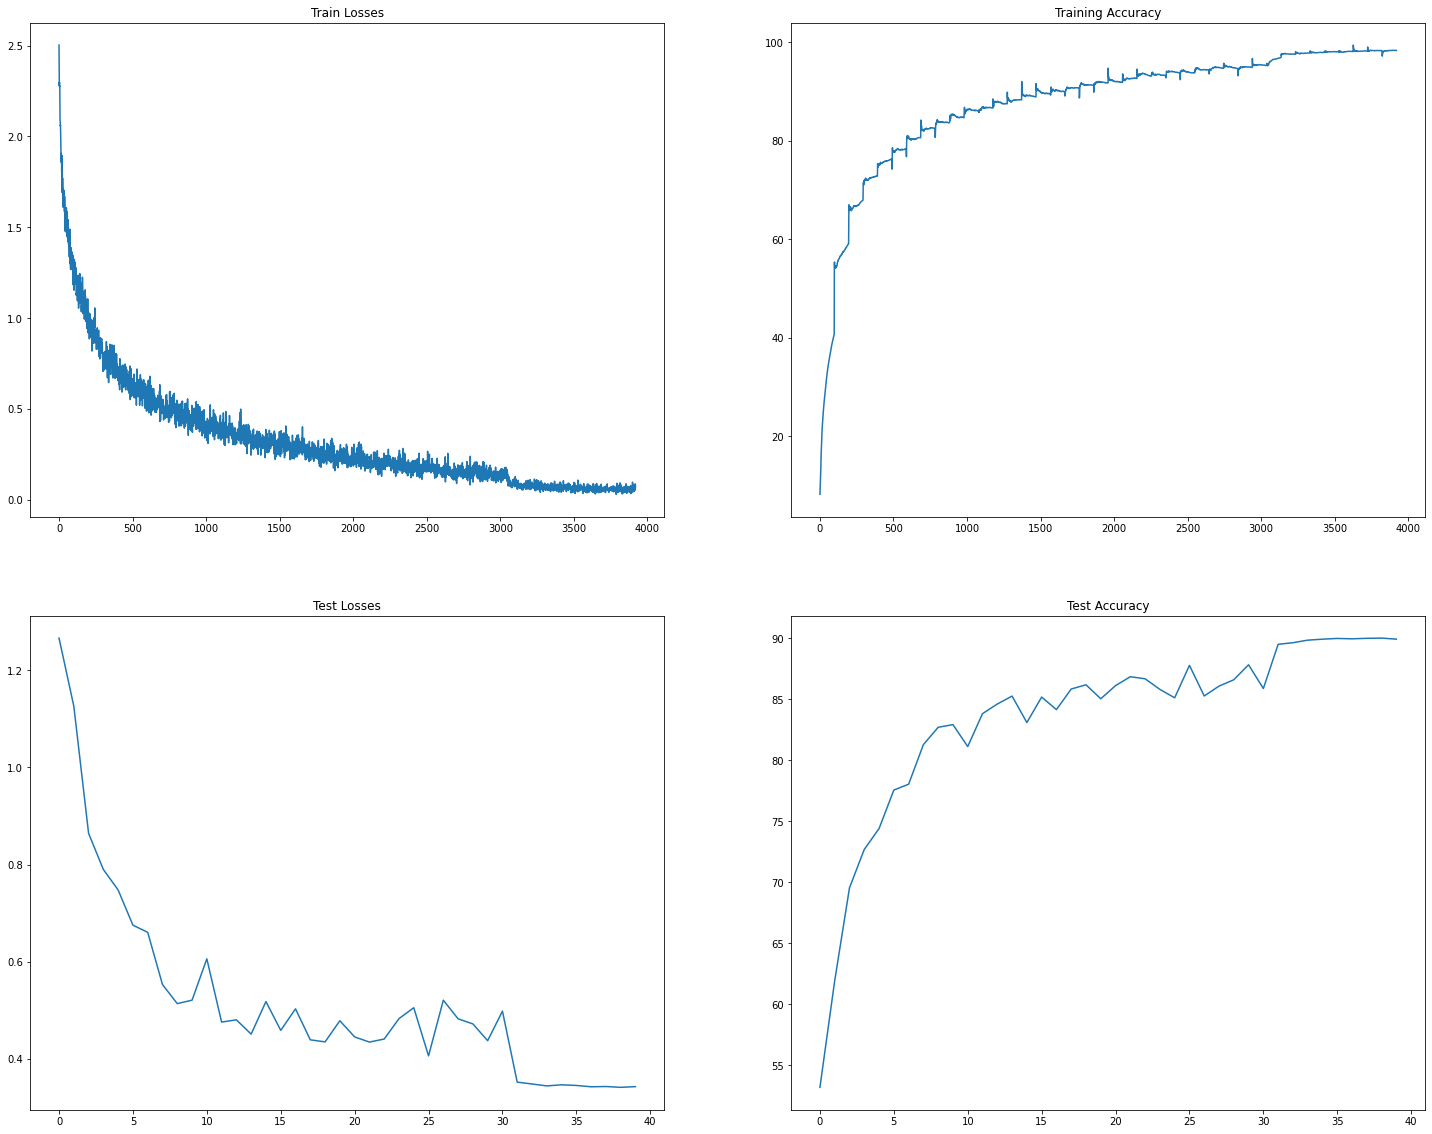

In [41]:
fig, axs = plt.subplots(2,2, figsize=(25,20))

axs[0,0].set_title('Train Losses')
axs[0,1].set_title('Training Accuracy')
axs[1,0].set_title('Test Losses')
axs[1,1].set_title('Test Accuracy')

axs[0,0].plot(train_losses)
axs[0,1].plot(train_acc)
axs[1,0].plot(test_losses)
axs[1,1].plot(test_acc)